<div style="border:solid blue 2px; padding: 20px"> 

<strong>Reviewer's Introduction</strong>

Hello Magdalene! 👋 

I'm happy to review your project today.

I will categorize my comments in green, blue or red boxes like this:

<div class="alert alert-success">
    <b>Success:</b> Everything is done successfully.
</div>
<div class="alert alert-warning">
    <b>Remarks:</b> Suggestions for optimizations or improvements.
</div>
<div class="alert alert-danger">
    <b>Needs fixing:</b> This must be fixed for a project to be approved.
</div>

Please don't remove my comments :) If you have any questions or comments, don't hesitate to respond to my comments by creating a box that looks like this: 
<div class="alert alert-info"> <b>Student's comment:</b> Your text here.</div>    
<br>


📌 Here's how to create code for student comments inside a Markdown cell:
    
    
    <div class="alert alert-info">
    <b> Student's comment</b>

    Your text here. 
    </div>

You can find out how to **format text** in a Markdown cell or how to **add links** [here](https://sqlbak.com/blog/jupyter-notebook-markdown-cheatsheet). 


<hr>
Reviewer: Han Lee <br>
</div>



<div style="border: solid blue 2px; padding: 15px; margin: 10px">
	<b>Reviewer's Comments – Iteration 1</b>

Congratulations! 

This project meets all requirements ✅, and is approved. 🎉


<b>Notable strengths:</b>  

✔️ Thorough EDA

✔️ Clear and persuasive analyses and discussions throughout, including conclusion

✔️ Excellent use of CNN models and model parameters

Well done on a project dealing with a complex subject, and keep up the great work as you near the conclusion of the course.

</div>


## Introduction

The purpose of this project is to create a computer vision system for the supermarket chain Good Seed. The system will process customers' photos to determine the age of customers who are purchasing alcohol based products. This system will help Good Seed to abide by alcohol laws and ensure that they do not sell alcohol based products to underage customers. 

I will build and evaluate a model that will be used in this system to verify a customer's age based on their photo. 

## Initialization

## Download libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

import warnings 
warnings.filterwarnings("ignore", category=RuntimeWarning)


## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
df.info()
print('')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB



,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
df.duplicated().sum()

0

In [5]:
df.isnull().sum()

file_name    0
real_age     0
dtype: int64

A review of the dataset reveals that it contains 2 columns and 7,591 rows.

The file_name column is a picture-based file, indicated by a unique 6-digit number.
The real_age column indicates the age of the person in the picture.

The data set contains no missing values and no duplicates.

Additionally, all datatypes appear to be appropriate.

Given the number of images and the type of model that will be built, it is essential to ensure that our model reads the data sequentially, rather than all at once. Therefore, I will set up an ImageDataGenerator. I will do this during the modeling phase of this project.

## EDA

During the Exploratory Data Analysis (EDA) phase, I will examine the distribution of ages in the dataset, as well as a sample of the images, to gain a deeper understanding of the information provided.

In [6]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


A review of the statistical information shows that the minimum age in the dataset is 1 and the maximum age is 100. The median age is 29, while the mean is 31.2. This indicates that there is a positive skew in the data. The majority of the images are concentrated on individuals who are between 20 and 41 years of age. 

In the US, the legal drinking age is 21. Assuming that Good Seed is a US-based company, it appears that 25% of the data represents individuals who would be younger than the legal drinking age. That leaves 75% of the data representing individuals who are of a legal drinking age. 

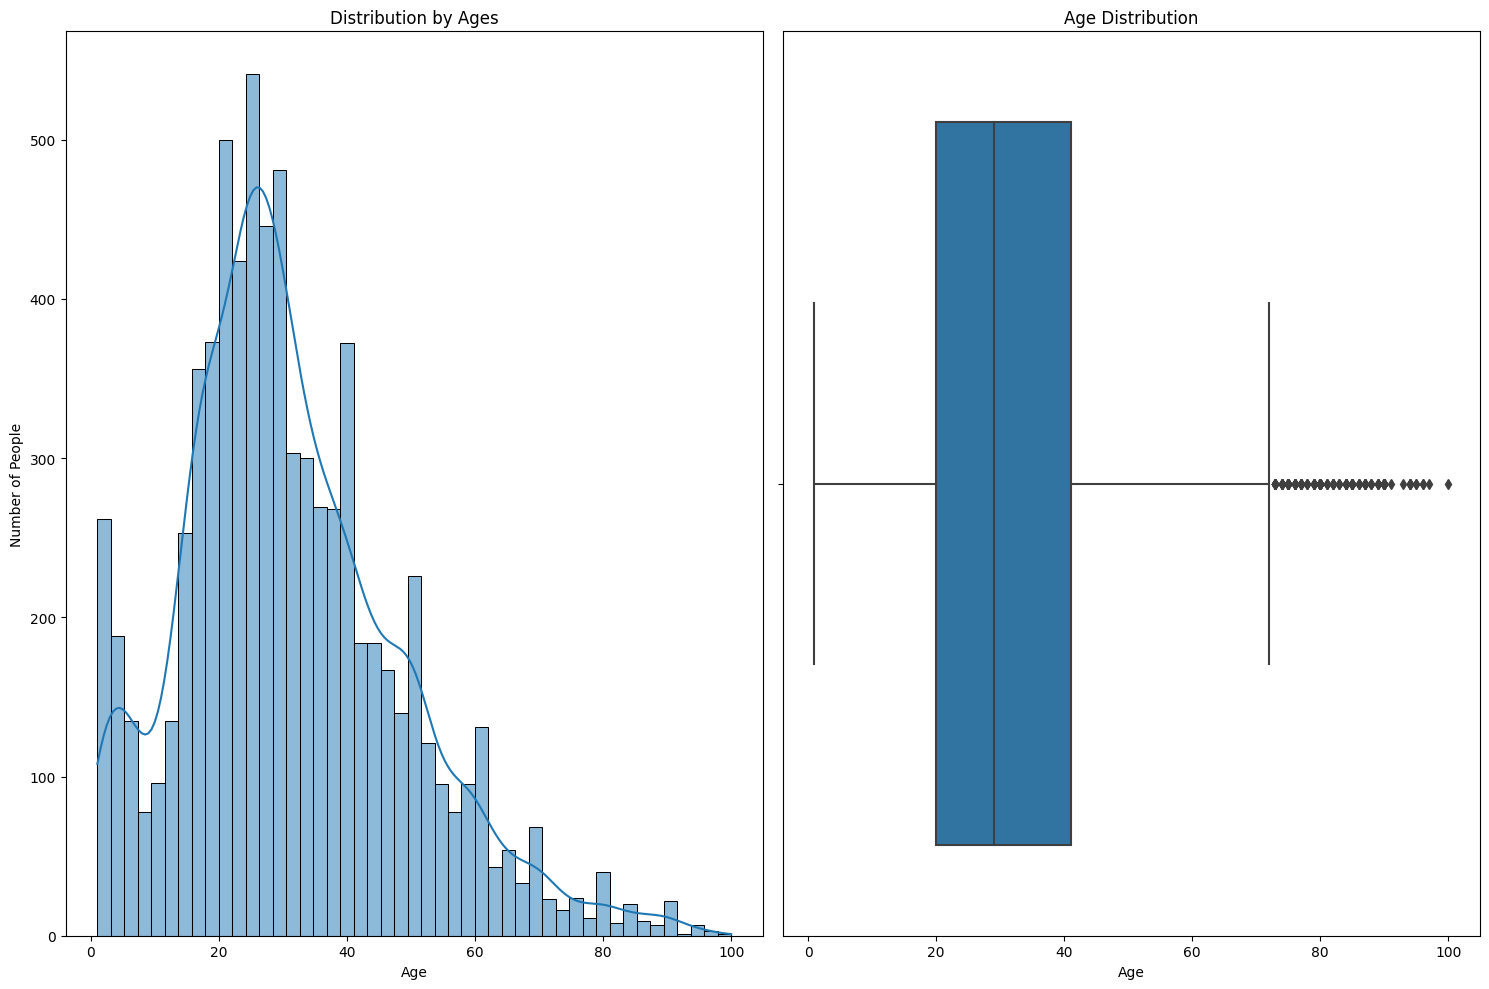

In [7]:
fig, ax= plt.subplots(1, 2, figsize=(15, 10))
sns.histplot(data=df, x='real_age', kde=True, ax=ax[0])
sns.boxplot(x="real_age", data=df, ax=ax[1])
ax[0].set_title("Distribution by Ages")
ax[1].set_title("Age Distribution")
ax[0].set(xlabel='Age', ylabel='Number of People')
ax[1].set_xlabel('Age')
plt.tight_layout()
plt.show()                    


The graphs show that the distribution of ages is concentrated between 21-40 years of age as predicted.

There are multiple outliers on the right tail of the boxplot, as predicted as well. Under normal circumstances, data would be cleaned to eliminate these outliers for model training. However, it is essential for our predictive model to analyze a wide range of ages; therefore, the outliers will not be removed from this dataset. 


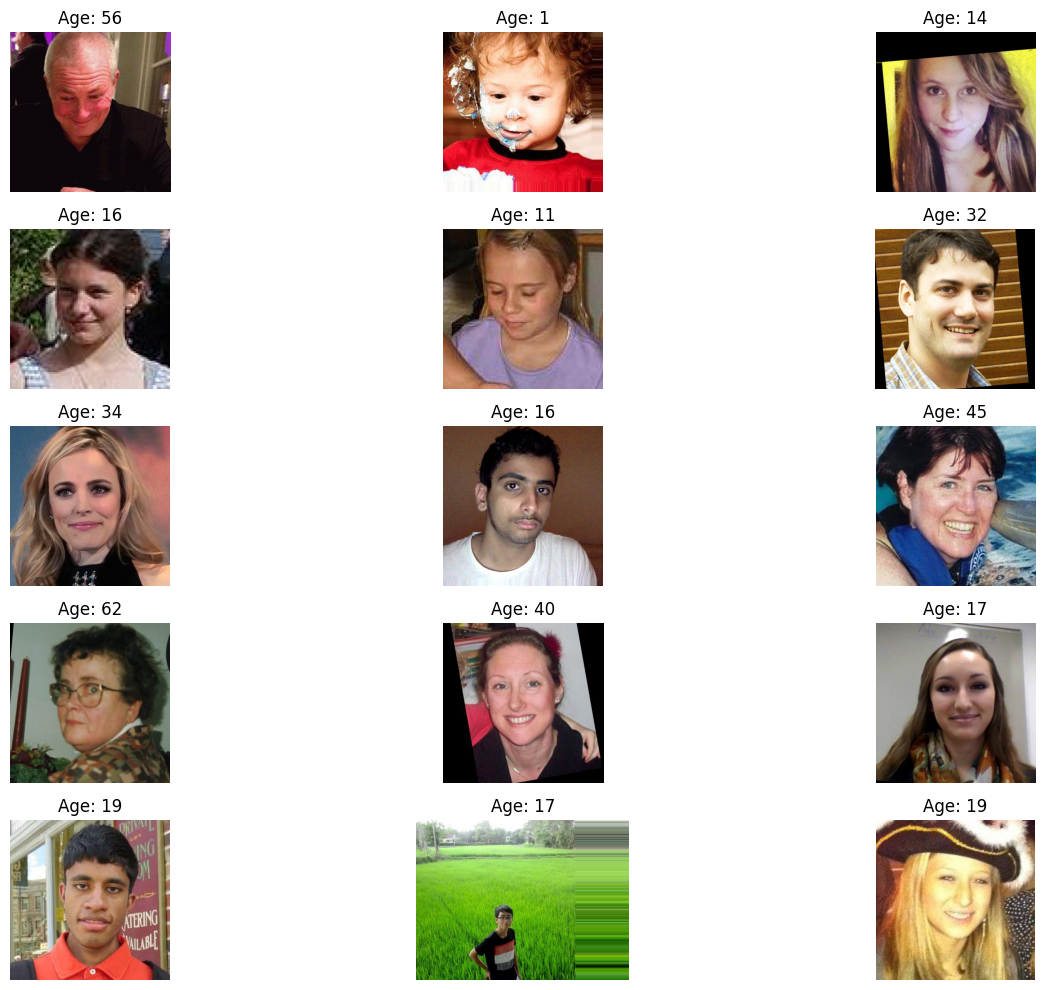

In [8]:
images = 15
rows = 5
columns = int(images/rows)

fig = plt.figure(figsize=(15, 10))
sample_data = df.sample(images)

for i, (inx, row) in enumerate(sample_data.iterrows()):
    fig.add_subplot(rows, columns, i+1)
    image_path = f'/datasets/faces/final_files/{row["file_name"]}'
    image = Image.open(image_path)
    
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Age: {row["real_age"]}')

plt.tight_layout()
plt.show()

There are some concerns about the quality of the images as I review them. They include the following:
* Some images are in monochrome formats such as black and white or sepia
* Some images are taken from a profile view rather than a straightforward facial view
* Some images have thick black outlines around them
* Some images are blurry in nature, making it difficult to see features
* Some images are taken in poor lighting or dim conditions
* Some images appear to be taken from a distance, making it challenging to see clear details
* Some images are taken at angles, making the photo diagonal rather than straight up and down.
* Some images are of people looking down, off to the side, closed-eyed, or with sunglasses 


### Findings

The findings of the EDA were as follows:

* The data consisted of images of people between 1 and 100 years of age
* 25% of the data represented individuals under the age of 21 years old
* 75% of the data represented individuals aged 21 years or older
* 50% of the data comprised individuals 21-41 years of age.
* The data had a positive skew with a high number of outliers on the right of the data

The findings from the image overview were as follows:

* Several images were blurry
* Several images were not in color (black and white or sepia)
* Several images were of profile views instead of full frontal face shots
* Several images had black blocking around them
* Several images were taken in poor/dim lighting
* Several images were taken at an angle rather than straight up and down
* Several images were taken at a distance, making it difficult to see the person clearly
* Several images are of people looking down, off to the side, closed-eyed, or with sunglasses 


## Modeling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.


I will also be using an ImageDataGenerator to ensure that the model reads images sequentially rather than all at once.
I will also correct some of the issues with the images mentioned in the previous stage by adding arguments that will flip images, adjust brightness and contrast, help with blurring and sharpening photos, as well as stretch and compress photos.


In [9]:
def custom_preprocessing(img_array):
    img_array = adjust_contrast(img_array)
    img_array = random_blur(img_array)
    img_array = random_sharpen(img_array)
    
    return img_array

datagen = ImageDataGenerator(preprocessing_function=custom_preprocessing, validation_split=0.25, rescale=1/255.)
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    # place your code here
  
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1.0/255, 
                                       vertical_flip=True, 
                                       horizontal_flip=True, 
                                       rotation_range=25, 
                                       width_shift_range=.2, 
                                       height_shift_range=.2,
                                       zoom_range=.2)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    
    )


    return train_gen_flow

In [10]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    # place your code here
    test_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rescale=1.0/255, 
                                       vertical_flip=True, 
                                       horizontal_flip=True, 
                                       rotation_range=25, 
                                       width_shift_range=.2, 
                                       height_shift_range=.2,
                                       zoom_range=.2)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    
    )

    return test_gen_flow

In [1]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    # place your code here
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation= 'relu'))

    optimizer = Adam(learning_rate=0.0005)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

In [12]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    # place your code here
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)

    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data = test_data, 
              batch_size = batch_size, 
              epochs = epochs,
              steps_per_epoch = steps_per_epoch, 
              validation_steps = validation_steps, 
              verbose = 2)

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [13]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921


Epoch 2/20
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035


Epoch 3/20
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454


Epoch 4/20
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481


Epoch 5/20
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192


Epoch 6/20
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332


Epoch 7/20
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359


Epoch 8/20
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239


Epoch 9/20
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529


Epoch 10/20
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629


Epoch 11/20
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866


Epoch 12/20
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591


Epoch 13/20
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467


Epoch 14/20
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401


Epoch 15/20
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841


Epoch 16/20
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304


Epoch 17/20
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419

Epoch 18/20
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226

Epoch 19/20
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908


Epoch 20/20
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

### Analysis of the output


The results of the model show that the 17th Epoch yielded the best results with a validation mean absolute error score of 6.6419. But there is a relatively significant difference between the MAE and val_MAE scores (almost double). Additionally, there is a significant difference between the loss score on the training set of 17.3425 and the loss score of the testing set of 78.4369, suggesting that the model is overfitting on the training set. Techniques such as adjusting the learning rate, regularization, or adding an early stopping mechanism could help mitigate or reduce the overfitting that occurs on the training set. 


Depending on the data and outcomes, a val_MAE of 6.6419 could be considered acceptable. However, this model is being used to estimate the legal age of a customer purchasing alcohol. The model could have an error margin of approximately 6-7 years based on this MAE score. Therefore, unless the store employs an alternative verification process to confirm the age of a customer estimated to be between 14 and 28 years old, this particular model would not be the most suitable system for age verification. 

## Conclusions

The purpose of this project was to create a computer vision system for the supermarket chain Good Seed. The system needed to process customers' photos to determine the age of customers who are purchasing alcohol based products. This system would help Good Seed to abide by alcohol laws and ensure that they do not sell alcohol based products to underage customers.

I built and evaluated a model that would be used in this system to verify a customer's age based on their photo.



**Initialization**

To begin this project, I downloaded the necessary libraries and the dataset. I checked the data for missing and duplicate values. I found that no such values were present in the data and that the datatypes for the columns appeared appropriate for the information they contained.


**EDA**

I then completed exploratory data analysis to determine what information the data contained. 

The findings of the EDA were as follows:

* The data consisted of images of people between 1 and 100 years of age
* 25% of the data represented individuals under the age of 21 years old
* 75% of the data represented individuals aged 21 years or older
* 50% of the data comprised individuals 21-41 years of age
* The data had a positive skew with a high number of outliers on the right of the data


The findings from the image overview were as follows:

* Several images were blurry
* Several images were not in color (black and white or sepia)
* Several images were of profile views instead of full frontal face shots
* Several images had black blocking around them
* Several images were taken in poor/dim lighting
* Several images were taken at an angle rather than straight up and down
* Several images were taken at a distance, making it difficult to see the person clearly
* Several images are of people looking down, off to the side, closed-eyed, or with sunglasses




**Modeling**

Due to the nature of the data, a GPU was required to run the model; however, I did not have access to one at this time. I used the model provided for the creation and results process. 

For this phase of the project, I used an ImageDataGenerator to ensure that the model read images sequentially rather than all at once.
I also corrected some of the issues with the images mentioned in the previous stage by adding arguments that would flip images, adjust brightness and contrast, help with blurring and sharpening photos, as well as stretch and compress photos.



**Prepare the Script to Run on the GPU Platform**

I used the script provided and copied and pasted the results.

The results of the model showed that the 17th Epoch yielded the best results with a validation mean absolute error score of 6.6419. But there was a relatively significant difference between the MAE and val_MAE scores (almost double). Additionally, there was a significant difference between the loss score on the training set of 17.3425 and the loss score of the testing set of 78.4369, suggesting that the model was overfitting on the training set. Techniques such as adjusting the learning rate, regularization, or adding an early stopping mechanism could help mitigate or reduce the overfitting that occurs on the training set. 

Depending on the data and outcomes, a val_MAE of 6.6419 could be considered acceptable. However, this model is being used to estimate the legal age of a customer purchasing alcohol. The model could have an error margin of approximately 6-7 years based on this MAE score. Therefore, unless the store employs an alternative verification process to confirm the age of a customer estimated to be between 14 and 28 years old, this particular model would not be the most suitable system for age verification. 

That said, a model such as this could be used to predict products in a store, such as items from the produce or bakery sections.



# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training